In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
data_nsyc = pd.read_csv('data/no_SMOTE_yes_convert.csv')
data_ysyc = pd.read_csv('data/yes_SMOTENC_yes_convert.csv')

In [11]:
from sklearn.metrics import classification_report

def evaluate_model(model, X_test, y_test, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print(f"Classification report (threshold={threshold}):")
    print(classification_report(y_test, y_pred))

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

models = [
    ('Decision Tree', DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    })
]

### 1. NSYC

In [13]:
X = data_nsyc.drop('is_churned', axis=1)
y = data_nsyc['is_churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [14]:
for name, model, params in models:
    print(f"Training {name} ...")

    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_proba = best_model.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.3, 0.71, 0.01)
    best_thresh, best_macro_f1 = 0.5, 0

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
        f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
        macro_f1 = (f1_0 + f1_1) / 2

        if macro_f1 > best_macro_f1:
            best_macro_f1, best_thresh = macro_f1, t

    y_pred_best = (y_proba >= best_thresh).astype(int)

    print(f'{model}, No Smote, Yes Convert')
    print('best parameters', grid_search.best_params_)
    print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
    print('report', classification_report(y_test, y_pred_best))
    print('####################################################')

Training Decision Tree ...
DecisionTreeClassifier(), No Smote, Yes Convert
best parameters {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best threshold: 0.66, Macro F1: 0.7189
report               precision    recall  f1-score   support

           0       0.55      0.54      0.55       601
           1       0.89      0.89      0.89      2487

    accuracy                           0.83      3088
   macro avg       0.72      0.72      0.72      3088
weighted avg       0.82      0.83      0.82      3088

####################################################


### 2. YSYC

In [15]:
X = data_ysyc.drop('is_churned', axis=1)
y = data_ysyc['is_churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [16]:
for name, model, params in models:
    print(f"Training {name} ...")

    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_index = grid_search.best_index_
    mean_f1 = grid_search.cv_results_['mean_test_score'][best_index]
    std_f1 = grid_search.cv_results_['std_test_score'][best_index]

    print(f"Best model CV mean F1: {mean_f1:.4f} (+/- {std_f1:.4f})")

    best_model = grid_search.best_estimator_
    y_proba = best_model.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.3, 0.71, 0.01)
    best_thresh, best_macro_f1 = 0.5, 0

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
        f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
        macro_f1 = (f1_0 + f1_1) / 2

        if macro_f1 > best_macro_f1:
            best_macro_f1, best_thresh = macro_f1, t

    y_pred_best = (y_proba >= best_thresh).astype(int)

    print(f'{name}, Yes Smote, Yes Convert')
    print('best parameters', grid_search.best_params_)
    print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
    print('report', classification_report(y_test, y_pred_best))
    print('####################################################')

Training Decision Tree ...
Best model CV mean F1: 0.8010 (+/- 0.0016)
Decision Tree, Yes Smote, Yes Convert
best parameters {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best threshold: 0.50, Macro F1: 0.8132
report               precision    recall  f1-score   support

           0       0.79      0.84      0.82      2487
           1       0.83      0.78      0.81      2487

    accuracy                           0.81      4974
   macro avg       0.81      0.81      0.81      4974
weighted avg       0.81      0.81      0.81      4974

####################################################


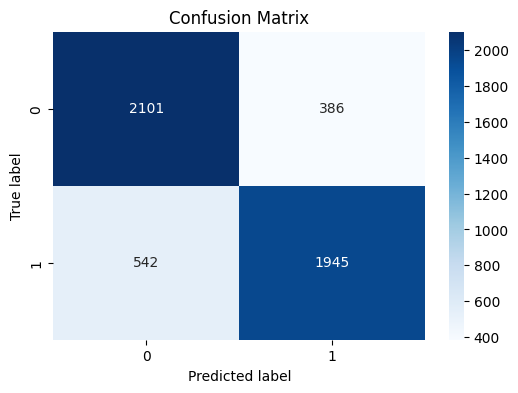

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import joblib

filename = f'{name}_best_model.pkl'
joblib.dump(best_model, filename)
print(f'Model saved to {filename}')

Model saved to Decision Tree_best_model.pkl


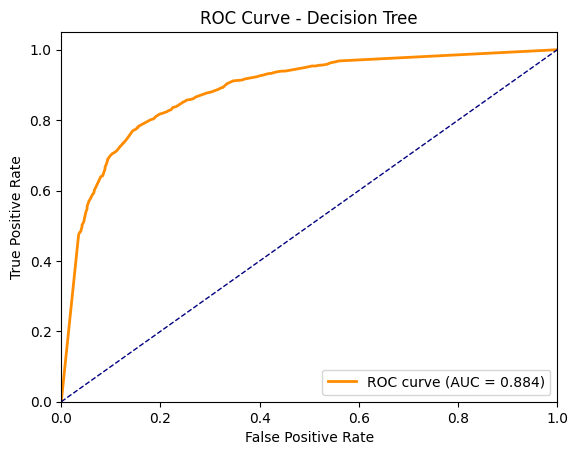

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 최적 모델로 테스트셋 확률 예측 (이미 y_proba 있음)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {name}')
plt.legend(loc="lower right")
plt.show()

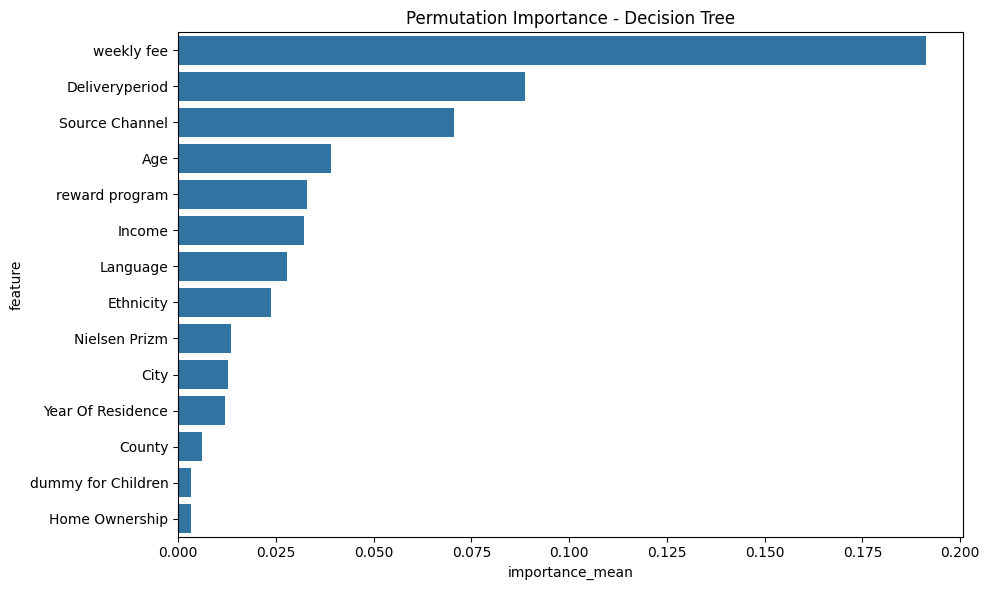

In [20]:
from sklearn.inspection import permutation_importance
import pandas as pd
import seaborn as sns

# test 데이터를 기준으로 permutation importance 계산
result = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# 중요도 정리
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

importance_df = importance_df.sort_values(by='importance_mean', ascending=False)

# 시각화
plt.figure(figsize=(10,6))
sns.barplot(x='importance_mean', y='feature', data=importance_df)
plt.title(f'Permutation Importance - {name}')
plt.tight_layout()
plt.show()

In [21]:
importance_df_neg = importance_df[importance_df['importance_mean'] < 0]

if not importance_df_neg.empty:
    # 음수 중요도 변수 내림차순(절댓값 기준) 정렬 (그래프용으로는 오름차순)
    importance_df_neg_sorted = importance_df_neg.sort_values(by='importance_mean', ascending=True).head(15)

    print("Features with Negative Permutation Importance:")
    print(importance_df_neg_sorted)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df_neg_sorted['feature'], importance_df_neg_sorted['importance_mean'], color='salmon')
    plt.xlabel('Permutation Importance (Mean)')
    plt.title('Features with Negative Permutation Importance')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No features with negative permutation importance.")

No features with negative permutation importance.
